<a href="https://www.kaggle.com/code/burcakaydn/store-item-demand-forcasting?scriptVersionId=170354675" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [3]:

########################
# Loading the data
########################

train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')

df = pd.concat([train, test], sort=False)


In [4]:
#####################################################
# EDA
#####################################################

df["date"].min(), df["date"].max()

check_df(df)

df[["store"]].nunique()

df[["item"]].nunique()

df.groupby(["store"])["item"].nunique()

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

df.head()


##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [5]:
#####################################################
# FEATURE ENGINEERING
#####################################################

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [6]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))



In [7]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

df.groupby(["store", "item"])['sales'].head()

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))



0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [8]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])


In [9]:

########################
# Rolling Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [10]:
########################
# Exponentially Weighted Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)


In [11]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])



In [12]:
########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)


In [13]:
#####################################################
# Model
#####################################################

########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [14]:
########################
# Time-Based Validation Sets
########################

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 142), (45000,), (45000, 142))

In [15]:
########################
# LightGBM ile Zaman Serisi Modeli
########################
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [16]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [17]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.408737 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513453	training's SMAPE: 17.5986	valid_1's l2: 0.0530799	valid_1's SMAPE: 17.4531
[200]	training's l2: 0.0352376	training's SMAPE: 14.572	valid_1's l2: 0.0369726	valid_1's SMAPE: 14.8833
[300]	training's l2: 0.0324487	training's SMAPE: 14.0143	valid_1's l2: 0.0340552	valid_1's SMAPE: 14.4204
[400]	training's l2: 0.0313649	training's SMAPE: 13.7966	valid_1's l2: 0.0332343	valid_1's SMAPE: 14.2697
[500]	training's l2: 0.0307021	training's SMAPE: 13.6623	valid_1's l2: 0.0325838	valid_1's SMAPE: 14.1265
[600]	training's l2: 0.0302371	training's SMAPE: 13.5663	valid_1's l2: 0.0321342	valid_1's SMAPE: 14.0214
[700]	training's l2: 0.0298969	training's SMAPE: 13.4961	valid_1's l2: 0.0318143	valid_1's SMAPE: 13.9498
[800]	training's l2: 0.0296136	t

In [18]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.824656740078154

                        feature  split       gain
17          sales_roll_mean_546    915  54.460507
13                sales_lag_364   1258  13.232289
16          sales_roll_mean_365    648   9.863422
60   sales_ewm_alpha_05_lag_365    403   5.007448
18   sales_ewm_alpha_095_lag_91     76   2.508070
..                          ...    ...        ...
78                       item_6      0   0.000000
111                     item_39      0   0.000000
86                      item_14      0   0.000000
115                     item_43      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


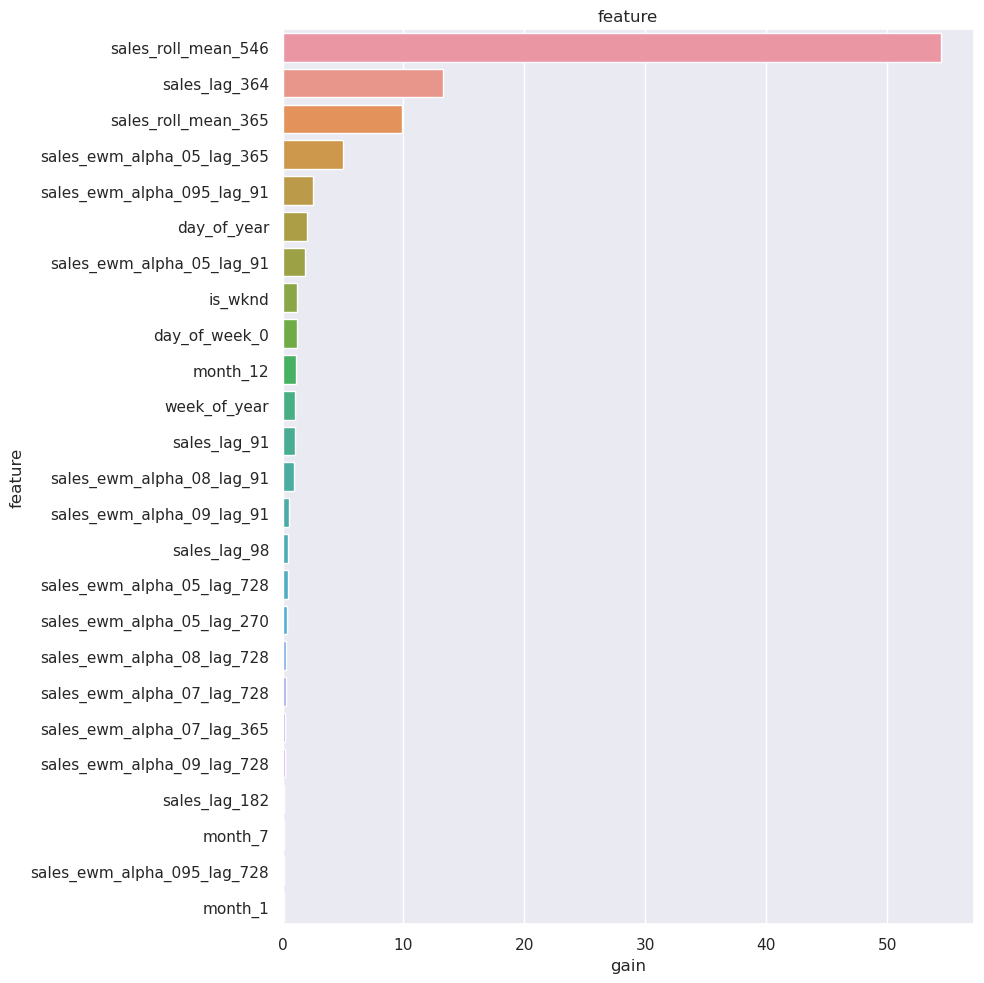

                        feature  split       gain
17          sales_roll_mean_546    915  54.460507
13                sales_lag_364   1258  13.232289
16          sales_roll_mean_365    648   9.863422
60   sales_ewm_alpha_05_lag_365    403   5.007448
18   sales_ewm_alpha_095_lag_91     76   2.508070
..                          ...    ...        ...
78                       item_6      0   0.000000
111                     item_39      0   0.000000
86                      item_14      0   0.000000
115                     item_43      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


110

In [19]:

########################
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)
plot_lgb_importances(model, num=30, plot=True)

feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)


In [20]:
########################
# Final Model
########################

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.507123 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [21]:
########################
# Submission File
########################

test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,11.201603,13.519795,20.358273,14.563751,11.961358,14.085324,16.195100,13.231195,20.564787,10.288701,26.225796,21.967322,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,15.616584,16.683137,23.429234,21.751525,28.073118,18.771206,24.345056,11.666085,34.368926,13.505119,23.732413,20.927384,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,13.281441,26.794373,21.392623,14.498945,25.045563,21.108250,24.541495,18.694889,20.626104,16.961447,23.193053,22.756737,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.53

In [22]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)